<a href="https://colab.research.google.com/github/Oleksij-gh/SentimentAnalysis/blob/main/Fine-tune%20distilbert-base-uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

https://www.kaggle.com/datasets/kazanova/sentiment140/data

In [ ]:
seed = 42

# 1. Libs

In [ ]:
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 4.9 MB/s eta 0:00:00


In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.40.1', '0.30.0')

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  torch import nn
import torch.nn.functional as F

%matplotlib inline

# 2. Dataset

## Train

In [ ]:
# Download data
!gdown 1-1tU8MXezIhyZKux01-C8PRwdI-JtBQX

Downloading...
From (original): https://drive.google.com/uc?id=1-1tU8MXezIhyZKux01-C8PRwdI-JtBQX
From (redirected): https://drive.google.com/uc?id=1-1tU8MXezIhyZKux01-C8PRwdI-JtBQX&confirm=t&uuid=2a71b72f-aca6-4bae-8feb-290ecabafab5
To: /content/df_redacted.csv
100% 157M/157M [00:02<00:00, 55.0MB/s]


In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/df_redacted.csv')
data = data.drop('Unnamed: 0', axis=1)
data = data.dropna()
data.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,positive
1,I am coming to the borders and I will kill you...,positive
2,im getting on borderlands and i will kill you ...,positive
3,im coming on borderlands and i will murder you...,positive
4,im getting on borderlands 2 and i will murder ...,positive


<Axes: xlabel='sentiment'>

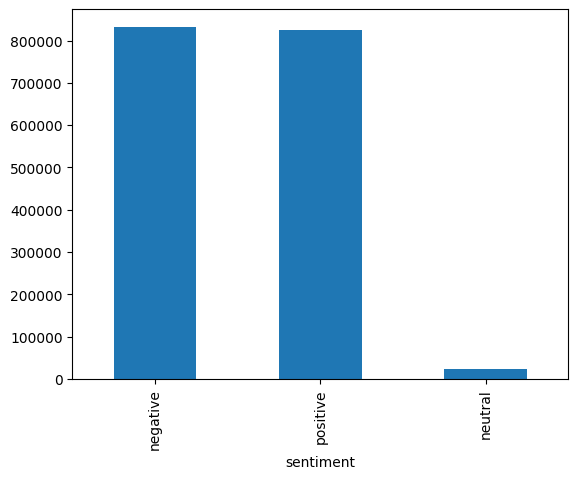

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')

In [ ]:
data.loc[data['sentiment'] == 'negative', 'sentiment'] = 0
data.loc[data['sentiment'] == 'neutral', 'sentiment'] = 1
data.loc[data['sentiment'] == 'positive', 'sentiment'] = 2

data['sentiment'] = data['sentiment'].astype(np.float16)
data.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,2.0
1,I am coming to the borders and I will kill you...,2.0
2,im getting on borderlands and i will kill you ...,2.0
3,im coming on borderlands and i will murder you...,2.0
4,im getting on borderlands 2 and i will murder ...,2.0


<Axes: xlabel='sentiment'>

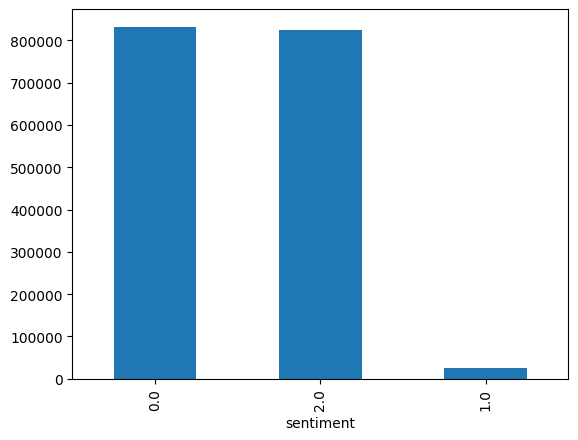

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split

X = data['text'].values
y = data['sentiment'].values

#from imblearn.under_sampling import RandomUnderSampler
#
#rus = RandomUnderSampler(random_state=seed, replacement=True)
#
#X, y = rus.fit_resample(X.reshape(-1, 1), y)

_, X_, _, y_ =\
    train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

X_train, X_test, y_train, y_test =\
    train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

# 3

In [ ]:
#import torch
#
#if torch.cuda.is_available():
#    device = torch.device("cuda")
#    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
#    print('Device name:', torch.cuda.get_device_name(0))
#
#else:
#    print('No GPU available, using the CPU instead.')
#    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
!pip install datasets --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.6 MB/s eta 0:00:00


In [ ]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
dataset = {'train':Dataset.from_dict({'label':y_train.astype(int),'text':X_train.astype(str)}),
     'test':Dataset.from_dict({'label':y_test.astype(int),'text':X_test.astype(str)})
     }

dataset = DatasetDict(dataset)

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = dataset['train'].map(preprocess_function, batched=True)
tokenized_test = dataset['test'].map(preprocess_function, batched=True)

Map:   0%|          | 0/269056 [00:00<?, ? examples/s]

Map:   0%|          | 0/67265 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)


In [ ]:
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model_1"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   #push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

Step,Training Loss
500,0.533300
1000,0.451600
1500,0.440800
2000,0.436900
2500,0.413300
3000,0.415100
3500,0.413200
4000,0.399700
4500,0.392100
5000,0.397600


TrainOutput(global_step=16816, training_loss=0.3647590985647505, metrics={'train_runtime': 2414.0353, 'train_samples_per_second': 222.91, 'train_steps_per_second': 6.966, 'total_flos': 7111523209532544.0, 'train_loss': 0.3647590985647505, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.3721390664577484,
 'eval_accuracy': 0.8467405039768081,
 'eval_f1': 0.8464545082620993,
 'eval_runtime': 91.718,
 'eval_samples_per_second': 733.39,
 'eval_steps_per_second': 22.929}

In [ ]:
from transformers import pipeline
sentiment_model = pipeline("sentiment-analysis", model="finetuning-sentiment-model/checkpoint-16816")

In [ ]:
sentiment_model(['@blizzard overwatch is good game'])

[{'label': 'LABEL_2', 'score': 0.9584380388259888}]

In [ ]:
!cp /content/finetuning-sentiment-model /content/drive/MyDrive/NLP-checkpoint -r

# Optuna

In [ ]:
!pip install optuna --quiet

In [ ]:
def optuna_hp_space(trial):

    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-7, 1e-3, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32, 64]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 10),
    }

In [ ]:
best_trials = trainer.hyperparameter_search(
    direction=["minimize"],
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20
)

[I 2024-05-13 10:20:50,751] A new study created in memory with name: no-name-a9aa2799-b7ee-43a9-b5c2-55928ac4145b
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.553400
1000,0.480200
1500,0.475900
2000,0.434400
2500,0.445400
3000,0.446800
3500,0.445500
4000,0.439200
4500,0.421700
5000,0.422100
